## Benchmarking C Foreign Function Performance

I wrote a naive 2D matrix multiplication algorithm using three approaches: pure Python, Python compiled using Numba's JIT compiler, and a C library called using `ctypes`.  These three approaches are compared across multiple matrix dimensions to demonstrate the speed-up obtained using C code.  Numpy matrix multiplication is also included in the comparison to provide a reference to a highly optimized linear algebra library.  The naive implementations are O(n<sup>3</sup>) algorithms and do not utilize any parallelism or code vectorization.

In [56]:
# Standard system imports
import ctypes
import pathlib

# Related third party imports
from numba import njit
import numpy as np

c_lib = ctypes.CDLL("../C/lib/libmatrix_mult.so") # Location of C shared library
mat_mult = c_lib.mat_mult

mat_mult.argtypes = [ctypes.c_int, ctypes.c_int, ctypes.c_int,
                  ctypes.POINTER(ctypes.c_double),
                  ctypes.POINTER(ctypes.c_double),
                  ctypes.POINTER(ctypes.c_double)]
mat_mult.restype = None  # C function returns void


In [57]:
def create_mats(out1, inner, out2, rng):
    """Return 2D Numpy arrays with C double datatype as well as pointers to the arrays."""
    mat1 = rng.random((out1, inner), dtype=np.double)
    mat2 = rng.random((inner, out2), dtype=np.double)
    mat3 = np.zeros((out1, out2), dtype=np.double)

    mat1_ptr = mat1.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    mat2_ptr = mat2.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    mat3_ptr = mat3.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    
    return mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr
    
def c_mat_mult(out1, inner, out2, mat1_ptr, mat2_ptr, mat3_ptr):
    """Naive matrix multiplication implementation using a C extension."""
    mat_mult(out1, out2, inner, mat1_ptr, mat2_ptr, mat3_ptr)
    
def np_mat_mult(mat1, mat2):
    """Matrix multiplication implemented using Numpy."""
    return mat1 @ mat2
    
    
def python_mat_mult(out1, inner, out2, mat1, mat2, mat3):
    """Naive matrix multiplication implementation using Python."""
    for i in range(out1):
        for j in range (out2):
            mat3[i][j] = mat1[i][0] * mat2[0][j]
            for k in range(1, inner):
                mat3[i][j] += mat1[i][k] * mat2[k][j]
    return mat3
        
@njit
def numba_mat_mult(out1, inner, out2, mat1, mat2, mat3):
    """Naive matrix multiplication implementation using Numba's JIT compiler.
    
    Numba apparently cannot accept pointers to doubles.
    """
    for i in range(out1):
        for j in range (out2):
            mat3[i][j] = mat1[i][0] * mat2[0][j]
            for k in range(1, inner):
                mat3[i][j] += mat1[i][k] * mat2[k][j]
    return mat3

In [58]:
# Generate same set of random matrices using seed
mat_dim = 100
out1 = mat_dim
inner = mat_dim
out2 = mat_dim

def generate_matrices(mat_dim):
    rng = np.random.default_rng(12345)
    out1 = mat_dim
    inner = mat_dim
    out2 = mat_dim
    mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr = create_mats(out1, inner, out2, rng)
    return mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr

In [55]:
# Verify all methods return same results
mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr = generate_matrices(mat_dim)
python_result = python_mat_mult(out1, inner, out2, mat1, mat2, mat3)

mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr = generate_matrices(mat_dim)
numpy_result = np_mat_mult(mat1, mat2)

mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr = generate_matrices(mat_dim)
numba_result = numba_mat_mult(out1, inner, out2, mat1, mat2, mat3)

mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr = generate_matrices(mat_dim)
c_mat_mult(out1, inner, out2, mat1_ptr, mat2_ptr, mat3_ptr)
c_result = mat3

np.testing.assert_allclose(python_result, numpy_result, rtol=0, atol=1e-10)
np.testing.assert_allclose(python_result, numba_result, rtol=0, atol=1e-10)
np.testing.assert_allclose(python_result, c_result, rtol=0, atol=1e-10)

In [16]:
python_times = []
numpy_times = []
numba_times = []
c_times = []
mat_dims = np.array([10, 50, 100, 200])

for mat_dim in mat_dims:
    mat1, mat2, mat3, mat1_ptr, mat2_ptr, mat3_ptr = generate_matrices(mat_dim)
    run_time = %timeit -o python_mat_mult(mat_dim, mat_dim, mat_dim, mat1, mat2, mat3)
    python_times.append(run_time)
    run_time = %timeit -o np_mat_mult(mat1, mat2)
    numpy_times.append(run_time)
    run_time = %timeit -o numba_mat_mult(mat_dim, mat_dim, mat_dim, mat1, mat2, mat3)
    numba_times.append(run_time)
    run_time = %timeit -o numba_mat_mult(mat_dim, mat_dim, mat_dim, mat1, mat2, mat3)
    c_times.append(run_time)

997 µs ± 32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.34 µs ± 11.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
2.54 µs ± 18.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.61 µs ± 99.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
119 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.2 µs ± 20.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
183 µs ± 421 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
183 µs ± 917 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
938 ms ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
40 µs ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.45 ms ± 6.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.45 ms ± 5.52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
7.88 s ± 49.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
191 µs ± 33.1 µs per loop (mean ± std. dev. of 7 runs, 1000 l

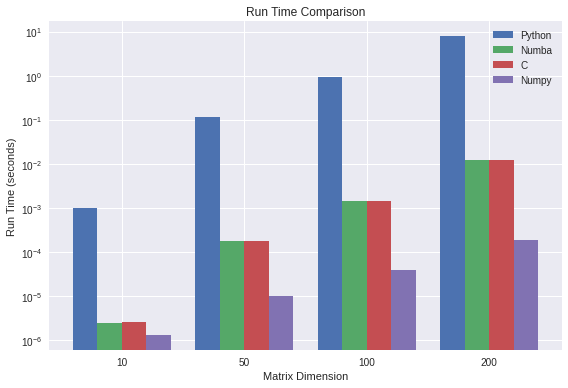

In [62]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn')

# Build the plot
bar_width = 0.2
x_spacing = np.arange(len(mat_dims))
fig, ax = plt.subplots()
ax.bar(x_spacing - bar_width*1.5, [x.average for x in python_times], bar_width, label="Python")
ax.bar(x_spacing - bar_width*.5, [x.average for x in numba_times], bar_width, label="Numba")
ax.bar(x_spacing + bar_width*.5, [x.average for x in c_times], bar_width, label="C")
ax.bar(x_spacing + bar_width*1.5, [x.average for x in numpy_times], bar_width, label="Numpy")

# Configure plot
ax.set_xlabel('Matrix Dimension')
ax.set_xticks(x_spacing)
ax.set_xticklabels(mat_dims)
ax.set_ylabel('Run Time (seconds)')
ax.set_yscale('log')
ax.set_title('Run Time Comparison')
plt.tight_layout()
plt.legend()
plt.show()

## Discussion

The above chart demonstrates that pure Python code is the slowest of the four approaches as expected, with Numba and the C code approaching a roughly 3 orders of magnitude speed-up in comparison.  The highly optimized Numpy library is the fastest of the four approaches, and is between 1 and 2 orders of magnitude faster than Numba and C.  Numpy uses either Intel MKL or OpenBLAS accelerated linear algebra libraries, and blows my simple nested FOR loop implementation out of the water.

The fact that Numba and the C code are neck-in-neck in terms of run time performance raises the question of whether the C foreign function approach should be discarded: after all, Numba allows the developer to write Python code and only requires a simple function decorator to implement the JIT compiler.

However, Numba is quite limited in what Python code it will accept, and finicky about how that Python code is written.  Numba supports a subset of the standard Python library as well as most Numpy functionality, but chokes on everything else.  In my opinion, working around all of Numba's limitations is tedious enough that one might as well just write C code.